# Predicting the Next Pandemic of Dengue
### Arima Models
by Brenda Hali

---
#### Importing Libraries

In [ ]:
#data manipualtion libraries
import pandas as pd
import numpy as np
import seaborn as sns

#data visualization
from matplotlib import pyplot as plt

#data modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

#Stats models
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import itertools

In [ ]:
from warnings import filterwarnings #Changes on and upgrades in Python generate warnings
filterwarnings('ignore') #We will 'mute' the warningss for now

#setting the plot style
#plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### Importing Datasets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
sj_train = pd.read_csv('/content/drive/My Drive/1. Documents/DSI/Capstone/predicting_next_pandemic_of_dengue/1-Data/4-sj_train.csv')
iq_train = pd.read_csv('/content/drive/My Drive/1. Documents/DSI/Capstone/predicting_next_pandemic_of_dengue/1-Data/5-iq_train.csv')

# sj_test = pd.read_csv('../1-Data/6-sj_test.csv')
# iq_test = pd.read_csv('../1-Data/7-iq_test.csv')

In [ ]:
sj_train.drop('Unnamed: 0', axis =1, inplace = True)
iq_train.drop('Unnamed: 0', axis =1, inplace = True)
# sj_test.drop('Unnamed: 0', axis =1, inplace = True)
# iq_test.drop('Unnamed: 0', axis =1, inplace = True)

In [6]:
sj_train.head()

,city,year,weekofyear,week_start_date,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.177617,12.42,297.572857,297.742857,292.414286,295.9,32.00,73.365714,12.42,14.012857,25.442857,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.155486,22.82,298.211429,298.442857,293.951429,296.4,17.94,77.368571,22.82,15.372857,26.714286,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.170843,34.54,298.781429,298.878571,295.434286,297.3,26.10,82.052857,34.54,16.848571,26.714286,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.235886,15.36,298.987143,299.228571,295.310000,297.0,13.90,80.337143,15.36,16.672857,27.471429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.247340,7.52,299.518571,299.664286,295.821429,297.5,12.20,80.460000,7.52,17.210000,28.942857,35.0,23.9,5.8,6


#### Modeling Baseline model

Splitting data into train and test 

In [ ]:
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

### Modeling for San Juan
We won't use the subtrain for now

In [ ]:
X = sj_train.drop('total_cases', axis=1)

y = sj_train[['week_start_date','total_cases']]

In [ ]:
y.index = pd.DatetimeIndex(X.week_start_date) #setting up the index as daytime
cases = y.total_cases

In [ ]:
sj_monthly = cases.resample('M').sum()

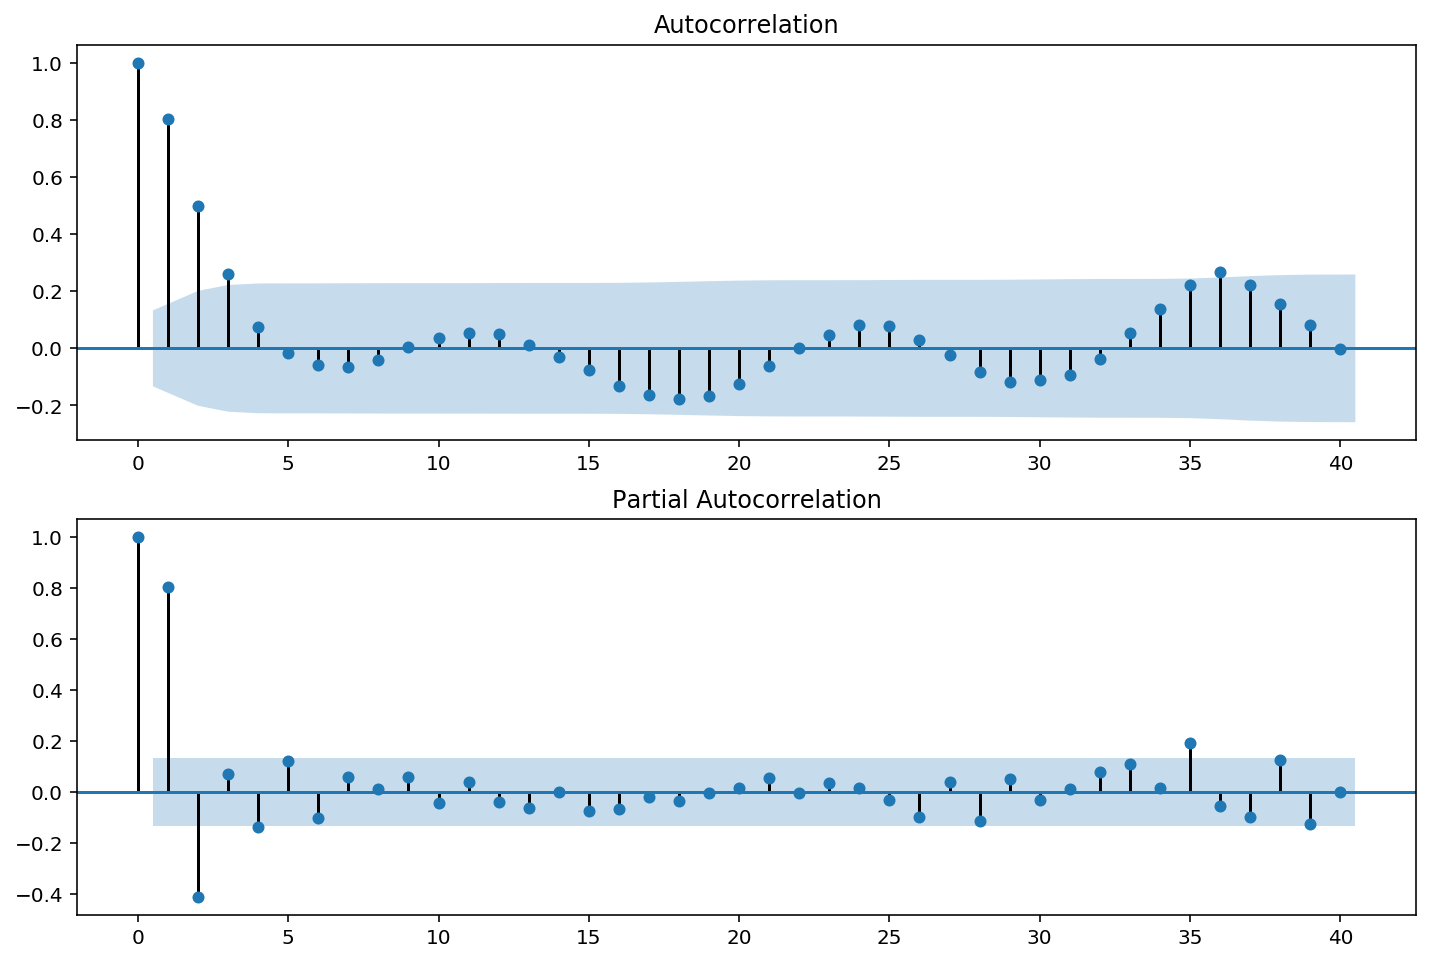

In [11]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sj_monthly, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sj_monthly, lags=40, ax=ax2)

- AR: There is significant autocorrelation at lags upto 3 or even 4
- I: Periodicity occurs at every 12th month, which is expected
- MA: There is a clear partial auto correlation until lag 3

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [ ]:
pdq = [(3,0,1),
       (3,0,2),
       (3,0,3),
       (3,0,4),
       (4,0,1),
       (4,0,2),
       (4,0,3),
       (4,0,4),
       (1,0,3),
       (2,0,3),
       (1,0,4),
       (2,0,4)]

In [ ]:
seasonal_pdq = [
       (3,2,2,12),
       (4,2,1,12),
       (4,2,2,12),
       (2,2,3,12),
       (1,2,4,12),
       (2,2,4,12)]

In [ ]:
optimal_pdq = 0
optimal_seasonal_pdq = 0

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sj_monthly,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            if results.aic < best_aic:
                best_aic = results.aic
                optimal_pdq = param
                optimal_seasonal_pdq = param_seasonal

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [20]:
mod = sm.tsa.statespace.SARIMAX(sj_monthly, order=(4,1,3), seasonal_order=(1,1,1,12))
results = mod.fit()
print (results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        total_cases   No. Observations:                  217
Model:             SARIMAX(4, 1, 3)x(1, 1, 1, 12)   Log Likelihood               -1268.876
Date:                            Thu, 05 Dec 2019   AIC                           2557.753
Time:                                    12:57:38   BIC                           2590.934
Sample:                                04-30-1990   HQIC                          2571.175
                                     - 04-30-2008                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4823      4.264     -0.113      0.910      -8.839       7.875
ar.L2          0.6865      2.260   

In [ ]:

pred = results.predict()

In [22]:
mean_absolute_error(sj_monthly[:-1], pred.shift(-1).dropna().clip(0))


59.70412454402596

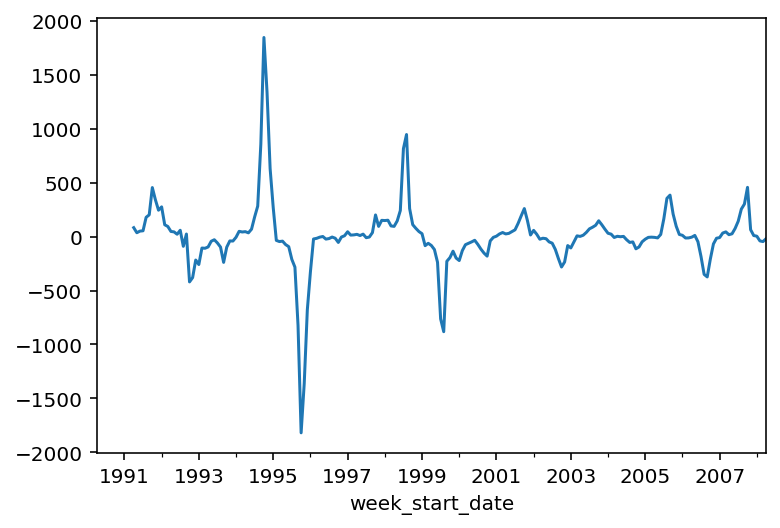

In [23]:
sj_monthly.diff(12).plot()

### Modeling for Iquitos
No we will look for the best parameters for Iquitos


In [ ]:
X = iq_train.drop('total_cases', axis=1)

y = iq_train[['week_start_date','total_cases']]

In [ ]:
y.index = pd.DatetimeIndex(X.week_start_date) #setting up the index as daytime
cases = y.total_cases

In [ ]:
iq_monthly = cases.resample('M').sum()

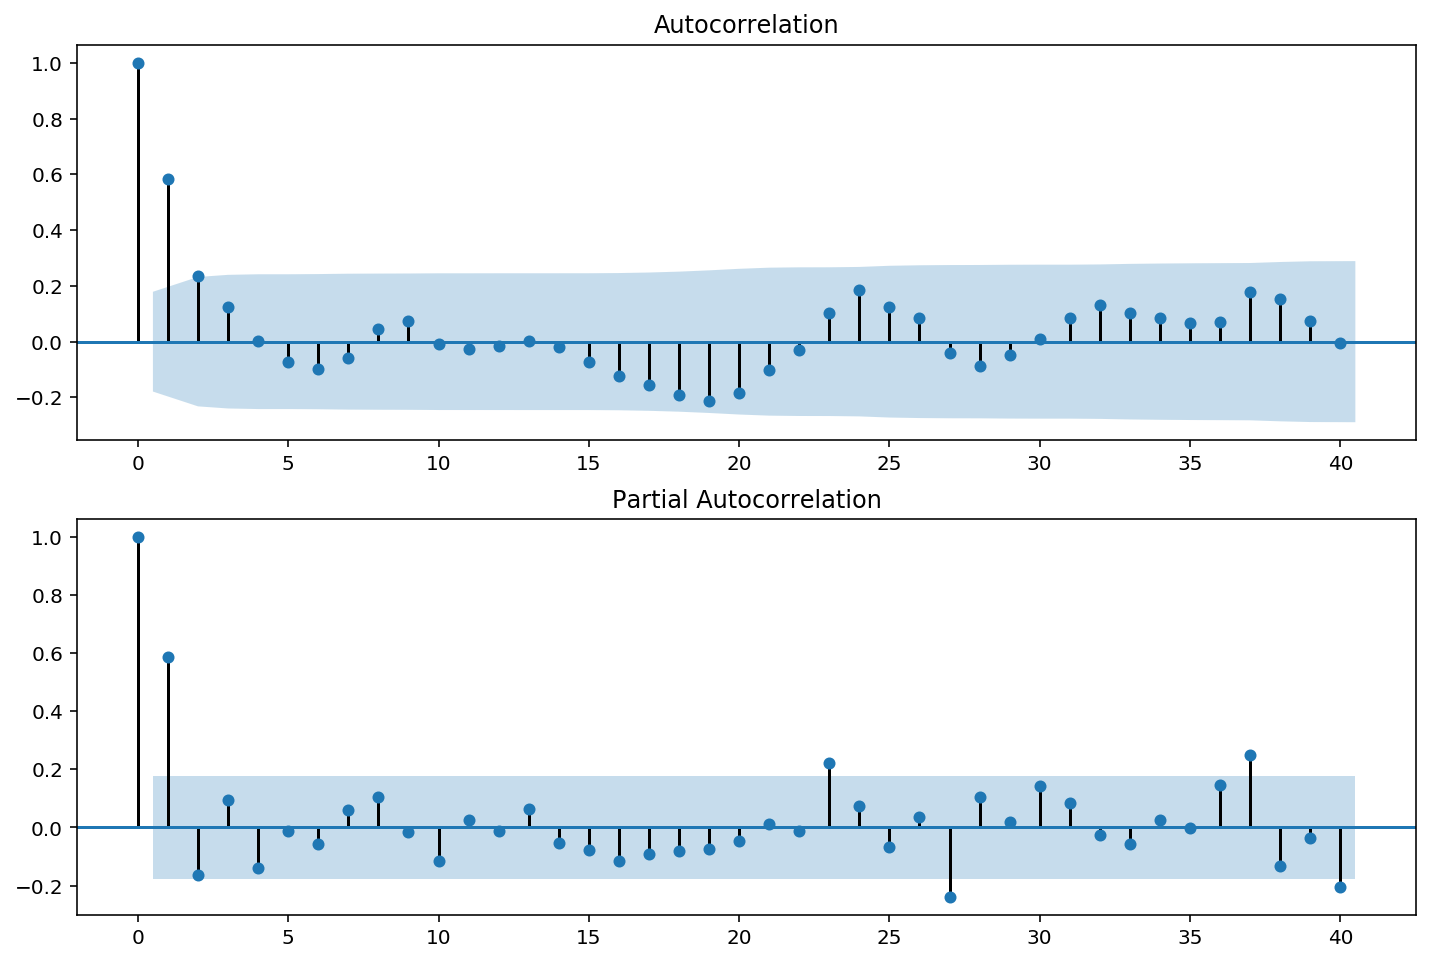

In [27]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(iq_monthly, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(iq_monthly, lags=40, ax=ax2)

- AR: There is significant autocorrelation at lags upto 3 or even 4
- I: Periodicity occurs at every 12th month, which is expected
- MA: There is a clear partial auto correlation until lag 3

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [ ]:
pdq = [(3,0,1),
       (3,0,2),
       (3,0,3),
       (3,0,4),
       (4,0,1),
       (4,0,2),
       (4,0,3),
       (4,0,4),
       (1,0,3),
       (2,0,3),
       (1,0,4),
       (2,0,4)]

In [ ]:
seasonal_pdq = [
       (3,2,2,12),
       (4,2,1,12),
       (4,2,2,12),
       (2,2,3,12),
       (1,2,4,12),
       (2,2,4,12)]

In [ ]:
optimal_pdq = 0
optimal_seasonal_pdq = 0

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(iq_monthly,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            if results.aic < best_aic:
                best_aic = results.aic
                optimal_pdq = param
                optimal_seasonal_pdq = param_seasonal

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [34]:
mod = sm.tsa.statespace.SARIMAX(sj_monthly, order=(4,1,3), seasonal_order=(1,1,1,12))
results = mod.fit()
print (results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        total_cases   No. Observations:                  217
Model:             SARIMAX(4, 1, 3)x(1, 1, 1, 12)   Log Likelihood               -1268.876
Date:                            Thu, 05 Dec 2019   AIC                           2557.753
Time:                                    13:10:04   BIC                           2590.934
Sample:                                04-30-1990   HQIC                          2571.175
                                     - 04-30-2008                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4823      4.264     -0.113      0.910      -8.839       7.875
ar.L2          0.6865      2.260   

In [ ]:

pred = results.predict()

In [36]:
mean_absolute_error(sj_monthly[:-1], pred.shift(-1).dropna().clip(0))


59.70412454402596

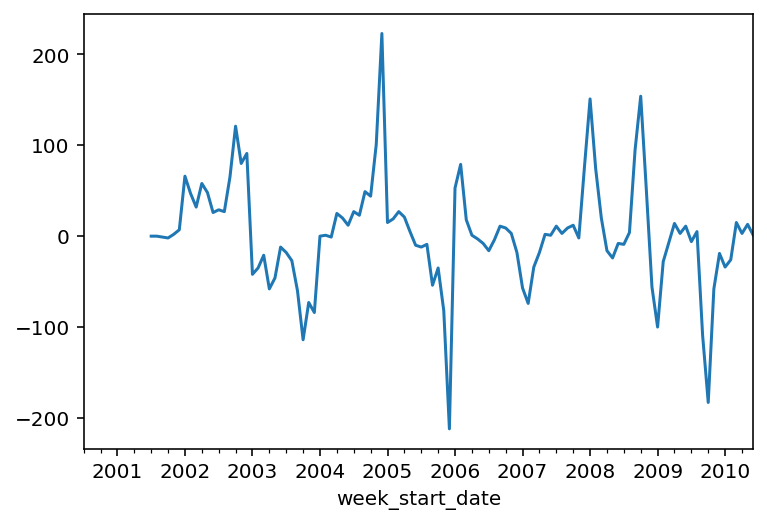

In [38]:
iq_monthly.diff(12).plot();